In [ ]:
# https://www.draw.io/#G0BweRoDuGcsLBOGVvUlFneUNGdDg
# https://github.com/metabolite-atlas/metatlas/blob/master/metatlas/h5_query.py

In [1]:
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pylab as plt
import sys
import glob, os

import sys

sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )

from metatlas import metatlas_objects as metob
from metatlas import h5_query as h5q
from metatlas import mzml_to_hdf

import tables

import pickle

import peakdetect

import numpy as np

The date got scrambled in the file names (it's correct on the folders though), it should have been 20151006 not 12151006 however it's consistent in all filenames. 
Here's an example file: NEG_12151006_PA_13C_fructose_TP1_5B_ORG.mzML
They all are in the same format: Polarity_Analysis start date_initials_label_compound_timepoint_soil sample name_extraction. 
There is probably more information in the search term than you need to pull this file list 'NEG_12151006_PA' would probably work fine but I know the one I copied (and tested) pulls out the correct files

In [2]:
# myRun = metob.queryDatabase('lcmsrun',mzml_file='%actino%',created_by='lpsilva',description='%C18_POS%')
# pol='NEG'
# searchterm=('%')
# pol ('_12151006_PA%TP%')
# myFiles = metob.retrieve('lcmsrun',name=searchterm)
# print len(myFiles)

myRun = metob.retrieve('lcmsrun',mzml_file='%NEG_12151006_PA%')
# myRun = metob.queryDatabase('lcmsrun',created_by='pandeer',mzml_file='%TLW%')
# myExperiment = metob.queryDatabase('Group')#,mzml_file='%global/homes/b/bpb/Actino_C18_Pos%')
# allCompounds = metob.queryDatabase('Compound')
# print len(allCompounds)



In [6]:
myRun[0].interact()

ImportError: cannot import name get_XIC

In [ ]:
# print len(myRun)
# for r in range(len(myRun)):
#     print myRun[r]

In [ ]:
# myfile = '/global/homes/b/bpb/ExoMetabolomic_Example_Data/MEDIA-1.h5'
# h5file = tables.open_file(myRun[0].hdf5_file)
# h5file
# myRun[0]

In [5]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster


MZ_GAUSS_WIDTH = 1 #ppm
MZ_MEDFILT_SIZE = 3 #bins

In [6]:
PEAK_THRESHOLD = 5000
MZSTART = 70
MZSTOP = 1050
PPM_BINNING = 2

NUM_MZ_EDGES = np.ceil(1e6*np.log(MZSTOP/MZSTART)/PPM_BINNING)
MZ_EDGES = np.logspace(np.log10(MZSTART), np.log10(MZSTOP), NUM_MZ_EDGES)

MZ_CENTERS = (MZ_EDGES[:-1] + MZ_EDGES[1:]) / 2
peaks = []
total_spectrum = np.zeros(MZ_CENTERS.shape)
for i,r in enumerate(myRun):
    with tables.open_file(r.hdf5_file) as h5file:
        mz,intensity = h5q.get_spectrogram(h5file,0,2,1,0,bins=MZ_EDGES)
        max_peaks, min_peaks = mpeakdet(intensity,PEAK_THRESHOLD,mz)
        total_spectra = total_spectrum + intensity
        peaks.append(max_peaks)
        print i


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


KeyboardInterrupt: 

In [ ]:
print len(intensity)
print len(mz)
print len(MZ_EDGES)
print len(MZ_CENTERS)

In [ ]:
total_spectrum = np.zeros(MZ_CENTERS.shape)
for i,r in enumerate(myRun):
    with tables.open_file(r.hdf5_file) as h5file:
        mz,intensity = h5q.get_spectrogram(h5file,0,20,1,0,bins=MZ_EDGES)
#         intensity = intensity - np.min(intensity)
#         intensity = intensity / np.max(intensity)
        total_spectrum = total_spectrum + intensity
        print i
        

In [13]:
np.save('pete_total_spectrum_intensity.npy',total_spectrum)
np.save('pete_total_spectrum_mz.npy',MZ_CENTERS)

In [122]:
total_spectrum = np.load('pete_total_spectrum_intensity.npy')
MZ_CENTERS = np.load('pete_total_spectrum_mz.npy')

In [14]:
x = MZ_CENTERS
y = total_spectrum

In [1]:
import sys
from numpy import NaN, Inf, arange, isscalar, array, asarray
 
def mpeakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
 
    return array(maxtab), array(mintab)

In [58]:
max_peaks, min_peaks = mpeakdet(y,2e5,x)

In [59]:
np.asarray(max_peaks).shape

(5243, 2)

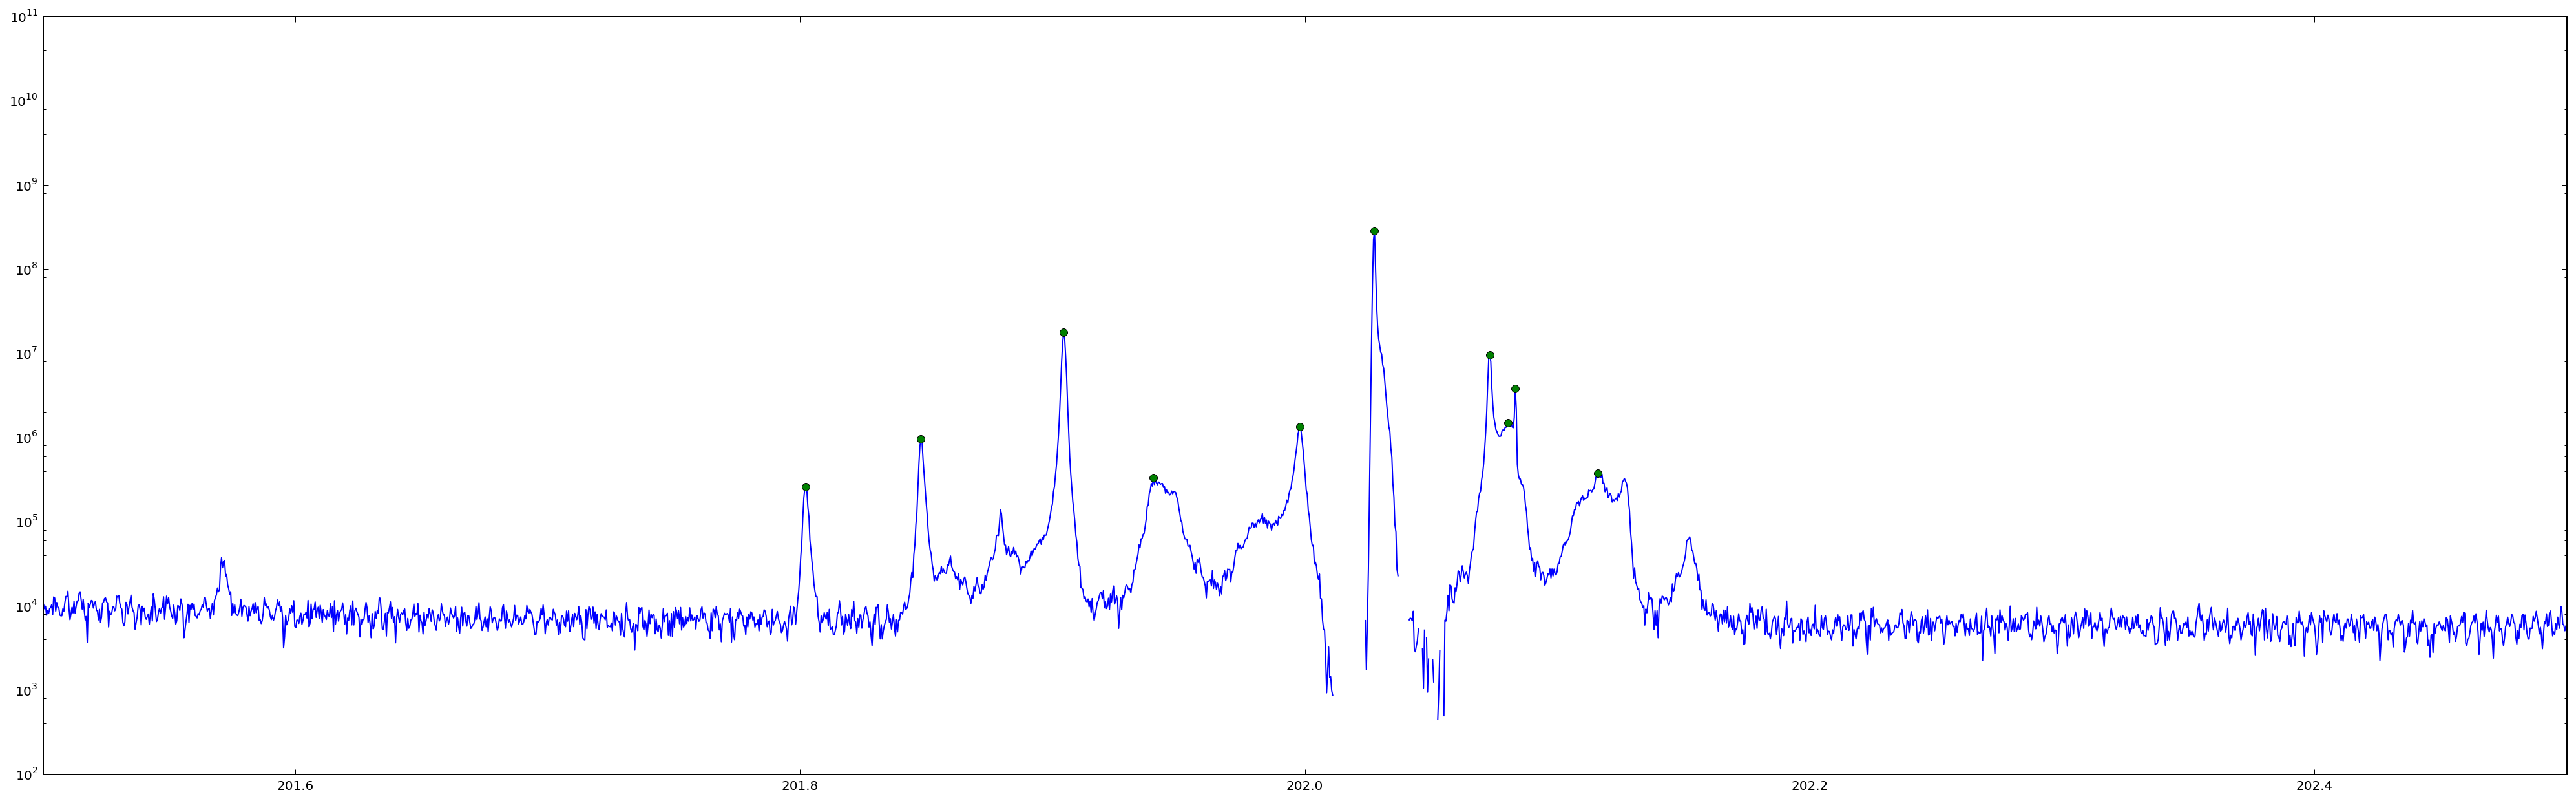

In [60]:
plt.semilogy(x,y)
plt.semilogy(np.asarray(max_peaks)[:,0],np.asarray(max_peaks)[:,1],'o')
plt.xlim(201.5,202.5)
fig = plt.gcf()
fig.set_size_inches(35, 10.5)
plt.show()

In [157]:

pd
# pks = np.zeros((len(this_peaks),2))
# pks[:,0] = this_peaks
# pd = pdist(pks)
# print len(pd)
# Z = linkage(pd, method='average')
# cluster = fcluster(Z,0.005,criterion = 'distance')  #,criterion='inconsistent') - 1

this_peaks = [100.0000,100.0001,101.0000,102.0000]
pd = pdist(np.asarray(this_peaks)[:,np.newaxis])
print pd
Z = linkage(pd, method='average')
cluster = fcluster(Z,0.005,criterion = 'distance')  #,criterion='inconsistent') - 1
print cluster

uc = np.unique(cluster)
print uc
all_peaks = []
for u in uc:
    idx = np.argwhere(cluster == u).flatten()
    temp = 0
    for j in idx:
        temp = temp + this_peaks[j]
    temp = temp / len(idx)
    
    all_peaks.append(temp) #TODO: this should be a weighted average
print all_peaks

 [  1.00000000e-04   1.00000000e+00   2.00000000e+00   9.99900000e-01
   1.99990000e+00   1.00000000e+00]
[1 1 2 3]
[1 2 3]
[100.00005, 101.0, 102.0]


In [169]:
all_spectra[0][0]

array([   70.00007   ,    70.00021   ,    70.00035   , ...,  1049.99475001,
        1049.99685001,  1049.99895   ])

In [ ]:
        
        max_peaks, min_peaks = mpeakdet(intensity,5000,mz)

        this_peaks = []
        for j in range(max_peaks.shape[0]):
            this_peaks.append(max_peaks[j,0])
        for p in all_peaks:
            this_peaks.append(p)
        pks = np.zeros((len(this_peaks),2))

        print i, r.hdf5_file
        print max_peaks.shape[0], "new peaks found"
        print len(all_peaks), "total # of aggregated peaks"
        print len(this_peaks), "new peaks + aggregated peaks"

#         pks[:,0] = this_peaks
        pd = pdist(np.asarray(this_peaks)[:,np.newaxis])
        print len(pd)
        Z = linkage(pd, method='average')
        cluster = fcluster(Z,0.005,criterion = 'distance')  #,criterion='inconsistent') - 1
        uc = np.unique(cluster)
        print len(uc)
        all_peaks = []
        for u in uc:
            idx = np.argwhere(cluster == u).flatten()
            temp = 0
            for j in idx:
                temp = temp + this_peaks[j]
                temp = temp / len(idx)
            all_peaks.append(temp)

        print len(all_peaks), "consolidated peaks"
        print " "


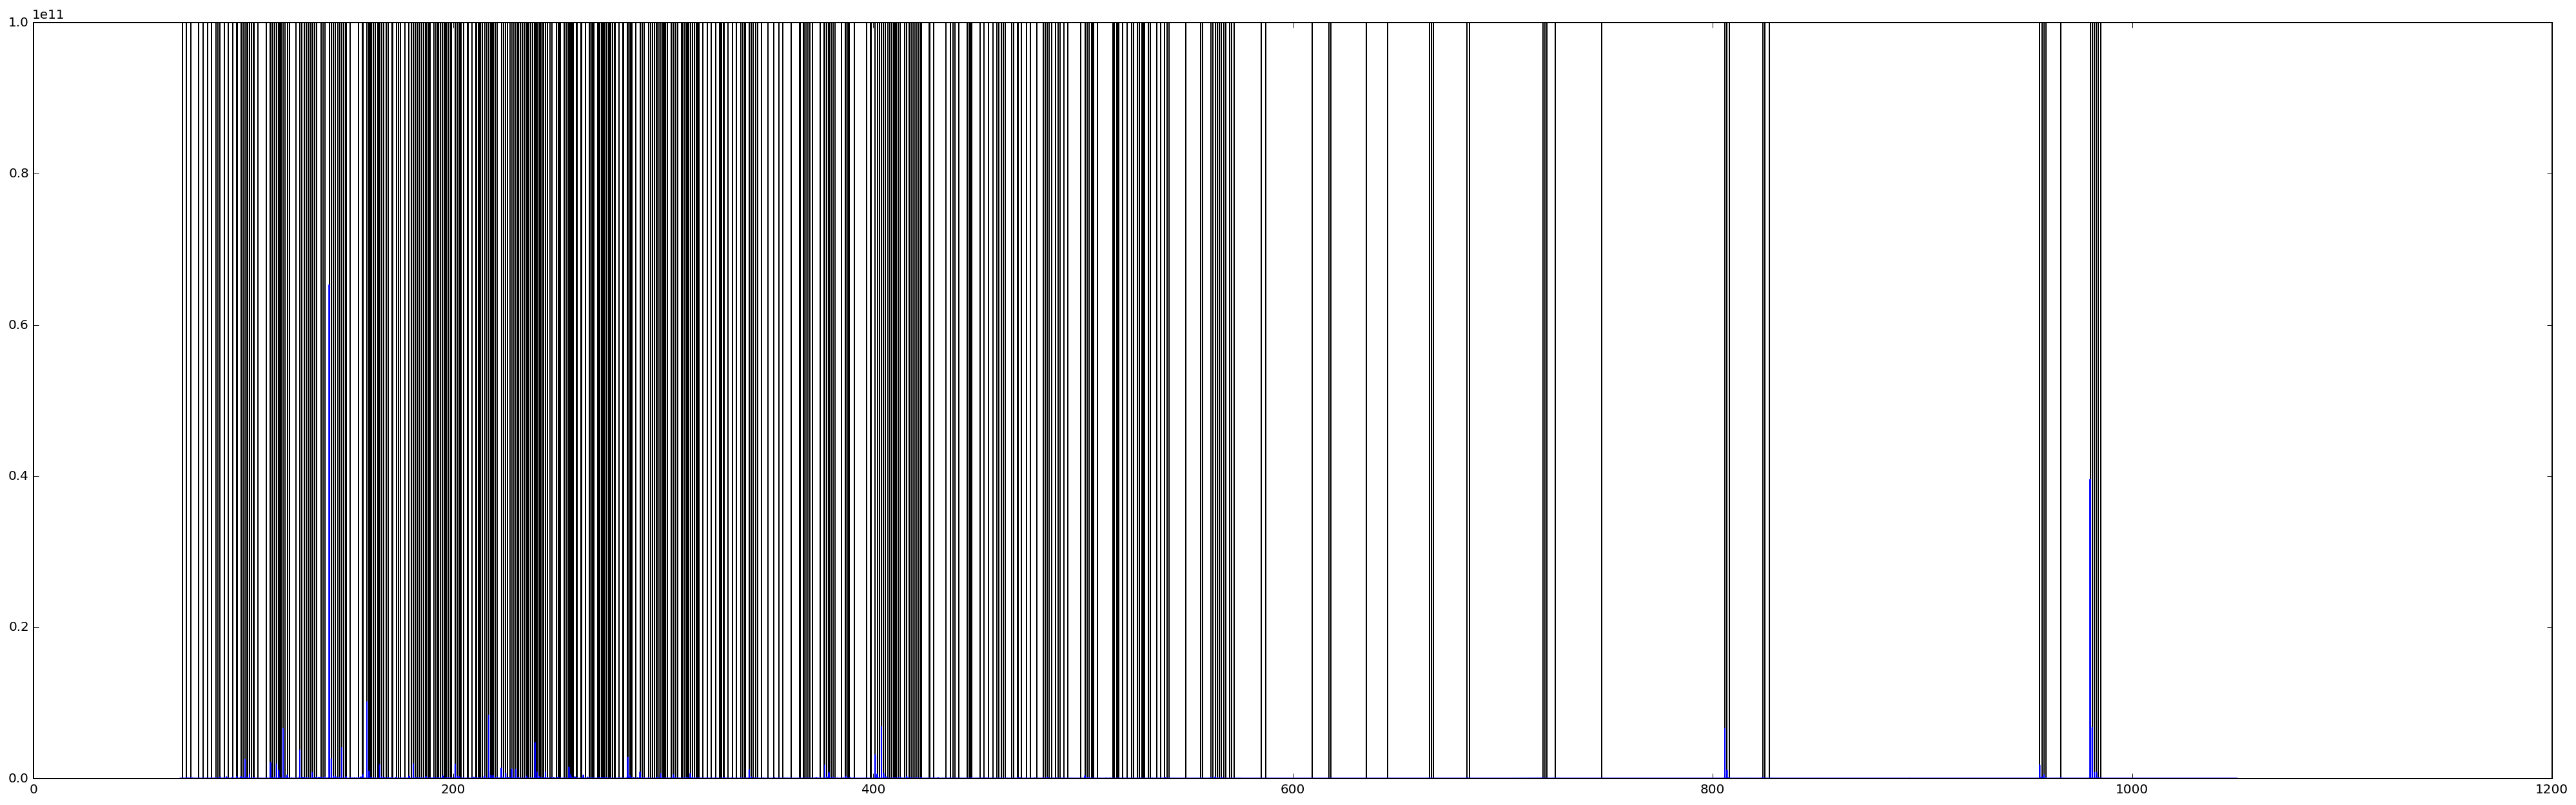

In [160]:

plt.plot(MZ_CENTERS,total_spectrum)
plt.vlines(all_peaks,np.zeros(len(all_peaks)),1e11+np.zeros((len(all_peaks))))
# plt.xlim(170.5,171.5)
# plt.ylim(0,1e5)
fig = plt.gcf()
fig.set_size_inches(35, 10.5)
plt.show()

In [73]:
print max_peaks.shape

(434, 2)


434
338
